# Cohort Case Study 1

In this first case study for the ``cohort`` submodule, we'll create a synthetic dataset that has some characteristics that will highlight the advantages of using pre-processing pipelines for each cohort separately instead of using it over the entire dataset.

Adopting a separate pipeline for each cohort is not an approach that will work in every situation. In fact, it is usually recommended to process the entire dataset instead of analyzing each cohort separately. But in some cases, certain cohorts behave differently from others, and the intensity of this difference will indicate if using a cohort-based pipeline is the best approach or not. When each cohort has a distinct behavior, *e.g.*, considerably different class distributions, different feature importance, opposite class behaviors, different value distribution for certain features, etc., then one cohort might end up degrading the performance of a model trained over the entire dataset when evaluated over the remaining cohorts. This is especially true when we have cohorts with very different behaviors, and one cohort that comprises the majority of the instances: in this case, the model trained over the entire dataset might simply learn how to predict the class of the instances of this majority cohort, and simply ignore the other cohorts. By doing this, the model will still achieve good results, but at the cost of neglecting the minority cohorts. This becomes a major concern when we are dealing with sensitive cohorts, that is, cohorts built with sensitive features, such as (but not limited to): gender, nationality, race, age, or a combination of these features. When a model performs well for one of the sensitive cohorts, but under-performs for the remaining cohorts, then the model is considered to be biased and may result in several legal problems. To mitigate these discrepancies, we might need to apply different pre-processing operations over each cohort separately, or even train different models for each cohort. 


## Creating the artificial dataset

Given that scenarios that benefit from using different data pipelines for each cohort are not common, in this first case study we'll use a synthetic dataset that is created to artificially create this scenario. Here are the main characteristics that we want to see in our dataset:

1. **Different cohorts and sub-cohorts that behave differently:** to simulate this, we can use different rules to establish each instance's class based on which cohort it belongs to. By doing this, a model will have a hard time understanding the general classification rule if trained with the entire dataset, since learning how to classify instances from one cohort may harm the classification capabilities for another cohort;
2. **Different value ranges and distributions for numerical features:** if the values for a feature vary considerably for different cohorts, we may find it useful to normalize these features separately for each cohort, instead of normalizing it for the entire dataset.

Our dataset will detail if a company went bankrupt (after a fixed number of months) or not. The only features used for each company are: the company's country's of origin, the industry sector to which it belongs, and the initial investment poured into the creation of the company measured in the company's country local currency. Each country has different local currency values, so it is expected that this feature varies based on the country's value. Also, due to each country's many characteristics (culture, environment, financial situation, social differences, etc.), each industry sector functions differently based on the country of the company. For example, a company that sells tropical fruits requires a lot less investment to succeed in tropical countries when compared to countries farther away from tropical areas. Finally, the rule adopted to define the class of each company (1 if the company went bankrupt, and 0 otherwise) is the following: if  the investment value is larger than a given threshold then the company succeeded (class 0). For some companies, however, this behavior is inverted: if the investment is larger than the threshold, the company goes bankrupt. This threshold is defined for each sector in each country.

We'll also add some noise to the dataset by adding some missing values in the ``investment`` column, as well as inverting a small percentage of the final classes.

In [1]:
import random
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.pipeline import Pipeline
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression

from raimitigations.utils import split_data, fetch_cohort_results
import raimitigations.dataprocessing as dp
from raimitigations.cohort import CohortDefinition, CohortManager

SEED = 51
#SEED = None
np.random.seed(SEED)
random.seed(SEED)

def _create_country_df(samples: int, sectors: dict, country_name: str):
    df = None
    for key in sectors.keys():
        size = int(samples * sectors[key]["prob_occur"])
        invest = np.random.uniform(low=sectors[key]["min"], high=sectors[key]["max"], size=size)
        min_invest = min(invest)
        max_invest = max(invest)
        range_invest = max_invest - min_invest
        bankrupt_th = sectors[key]["prob_success"] * range_invest
        inverted_behavior = sectors[key]["inverted_behavior"]
        bankrupt = []
        for i in range(invest.shape[0]):
            inst_class = 1
            if invest[i] > bankrupt_th:
                inst_class = 0
            if inverted_behavior:
                inst_class = int(not inst_class)
            bankrupt.append(inst_class)
        noise_ind = np.random.choice(range(size), int(size*0.05), replace=False)
        for ind in noise_ind:
            bankrupt[ind] = int(not bankrupt[ind])
        noise_ind = np.random.choice(range(size), int(size*0.1), replace=False)
        for ind in noise_ind:
            invest[ind] = np.nan
        
        country_col = [country_name for _ in range(size)]
        sector_col = [key for _ in range(size)]
        df_sector = pd.DataFrame({
            "investment":invest,
            "sector":sector_col,
            "country":country_col,
            "bankrupt":bankrupt
        })
        
        if df is None:
            df = df_sector
        else:
            df = pd.concat([df, df_sector], axis=0)
    return df

def create_df_multiple_distributions(samples: list):
    sectors_c1 = {
        "s1": {"prob_occur":0.5, "prob_success":0.99, "inverted_behavior":False, "min":2e6, "max":1e7},
        "s2": {"prob_occur":0.1, "prob_success":0.2, "inverted_behavior":False, "min":1e7, "max":1.5e9},
        "s3": {"prob_occur":0.1, "prob_success":0.9, "inverted_behavior":True, "min":1e9, "max":1e10},
        "s4": {"prob_occur":0.3, "prob_success":0.7, "inverted_behavior":False, "min":4e10, "max":9e13},
    }
    sectors_c2 = {
        "s1": {"prob_occur":0.1, "prob_success":0.6, "inverted_behavior":True, "min":1e3, "max":5e3},
        "s2": {"prob_occur":0.3, "prob_success":0.9, "inverted_behavior":False, "min":1e5, "max":1.5e6},
        "s3": {"prob_occur":0.5, "prob_success":0.3, "inverted_behavior":False, "min":5e4, "max":3e5},
        "s4": {"prob_occur":0.1, "prob_success":0.8, "inverted_behavior":False, "min":1e6, "max":1e7},
    }
    sectors_c3 = {
        "s1": {"prob_occur":0.3, "prob_success":0.9, "inverted_behavior":False, "min":3e2, "max":6e2},
        "s2": {"prob_occur":0.6, "prob_success":0.7, "inverted_behavior":False, "min":5e3, "max":9e3},
        "s3": {"prob_occur":0.07, "prob_success":0.6, "inverted_behavior":False, "min":4e3, "max":2e4},
        "s4": {"prob_occur":0.03, "prob_success":0.1, "inverted_behavior":True, "min":6e5, "max":1.3e6},
    }
    countries = {
        "A":{"sectors":sectors_c1, "sample_rate":0.85},
        "B":{"sectors":sectors_c2, "sample_rate":0.05},
        "C":{"sectors":sectors_c2, "sample_rate":0.1}
    }
    df = None
    for key in countries.keys():
        n_sample = int(samples * countries[key]["sample_rate"])
        df_c = _create_country_df(n_sample, countries[key]["sectors"], key)
        if df is None:
            df = df_c
        else:
            df = pd.concat([df, df_c], axis=0)
    
    idx = pd.Index([i for i in range(df.shape[0])])
    df = df.set_index(idx)
    return df

Let's now create our artificial dataset:

In [2]:
df = create_df_multiple_distributions(10000)
df

,investment,sector,country,bankrupt
0,7.405851e+06,s1,A,1
1,2.357697e+06,s1,A,1
2,4.746429e+06,s1,A,1
3,7.152158e+06,s1,A,1
4,NaN,s1,A,1
...,...,...,...,...
9995,4.226512e+06,s4,C,1
9996,3.566758e+06,s4,C,0
9997,9.281006e+06,s4,C,0
9998,5.770378e+06,s4,C,1


We'll now split our dataset into train and test sets:

In [3]:
X_train, X_test, y_train, y_test = split_data(df, label="bankrupt", test_size=0.3)

In [4]:
def get_model():
    #model = LGBMClassifier(random_state=SEED)
    model = LogisticRegression(random_state=SEED)
    return model

## Analyzing the "country" cohorts

Let's create our baseline model. We'll use a simple model since our goal is to test the efficiency of data processing pipelines, not test how different models behave. We'll create a pipeline with an imputer, a data normalization transformer, a one-hot encoding transformer, and finally our simple estimator. We'll then test our pipeline over the test set and analyze how this pipeline performs over different cohorts. This analysis is done using the ``fetch_cohort_results`` function, which shows the results obtained for the entire dataset, as well as for different cohorts. Notice that this function computes all metrics for each cohort separately, and therefore, different thresholds might be encountered for each cohort (the optimal threshold of a given set of predictions is found using the ROC curve). For now, we'll focus on the cohorts defined by the different countries in the dataset.

In [5]:
pipe = Pipeline([
            ("imputer", dp.BasicImputer(verbose=False)),
            ("scaler", dp.DataMinMaxScaler(verbose=False)),
            ("encoder", dp.EncoderOHE(verbose=False)),
            ("estimator", get_model()),
        ])
pipe.fit(X_train, y_train)
pred_org = pipe.predict_proba(X_test)
    
fetch_cohort_results(X_test, y_test, pred_org, cohort_col=["country"])

,cohort,cht_query,cht_size,roc,threshold,pr,recall,f1,acc
0,all,all,3000,0.803805,0.714791,0.788877,0.790533,0.769316,0.769333
1,cohort_0,"(`country` == ""A"")",2531,0.836172,0.714791,0.822146,0.833283,0.813916,0.814698
2,cohort_1,"(`country` == ""B"")",177,0.788575,0.176188,0.811737,0.794929,0.797184,0.802260
3,cohort_2,"(`country` == ""C"")",292,0.798822,0.234479,0.846590,0.830079,0.829746,0.832192


We can see that our pipeline managed to get a decent performance for all countries, despite the different behaviors that we injected for each cohort. However, since we have only a single estimator, we should consider only a single threshold for the entire dataset (the threshold referenced here is the threshold used to determine if a probability should be considered from class ``1`` or class ``0``). The function ``fetch_cohort_results()`` analyzes the results separately for each cohort, that is, all metrics are computed using the isolated predictions of each cohort. That is why we can see that each cohort used different thresholds (``threshold`` column). But if we use the same optimal threshold computed for the entire dataset for all cohorts (which makes sense in this case, since we have a single estimator), then we'll notice that the results are very different.

In [6]:
fetch_cohort_results(X_test, y_test, pred_org, cohort_col=["country"], shared_th=True)

,cohort,cht_query,cht_size,roc,threshold,pr,recall,f1,acc
0,all,all,3000,0.803805,0.714791,0.788877,0.790533,0.769316,0.769333
1,cohort_0,"(`country` == ""A"")",2531,0.836172,0.714791,0.822146,0.833283,0.813916,0.814698
2,cohort_1,"(`country` == ""B"")",177,0.788575,0.714791,0.579861,0.548716,0.486034,0.525424
3,cohort_2,"(`country` == ""C"")",292,0.798822,0.714791,0.550498,0.530459,0.475221,0.523973


For the sake of comparability, we'll use different thresholds for each cohort for all of our experiments from this point on. This will make our analysis more straightforward and easier to understand.

Let's see if we can improve these metrics by applying some pre-processing steps over each cohort separately. To that end, let's apply the imputation and normalization over each cohort separately and see how this impacts the resulting pipeline. We'll use the ``CohortManager`` class to achieve this.

In [7]:
cht_manager = CohortManager(
    transform_pipe=[
        dp.BasicImputer(verbose=False),
        dp.DataMinMaxScaler(verbose=False),
    ],
    cohort_col=["country"]
)

pipe = Pipeline([
            ("cht_preprocess", cht_manager),
            ("encoder", dp.EncoderOHE(verbose=False)),
            ("estimator", get_model()),
        ])
pipe.fit(X_train, y_train)
pred_cht = pipe.predict_proba(X_test)

fetch_cohort_results(X_test, y_test, pred_cht, cohort_col=["country"])

,cohort,cht_query,cht_size,roc,threshold,pr,recall,f1,acc
0,all,all,3000,0.814191,0.717450,0.795450,0.797449,0.776309,0.776333
1,cohort_0,"(`country` == ""A"")",2531,0.840887,0.717450,0.826792,0.838582,0.820110,0.821019
2,cohort_1,"(`country` == ""B"")",177,0.803594,0.372717,0.807712,0.809371,0.807609,0.807910
3,cohort_2,"(`country` == ""C"")",292,0.820083,0.265202,0.846590,0.830079,0.829746,0.832192


Unfortunately, we only achieved a slight performance increase. Let's now try using the same pipeline used for the baseline model, but this time each cohort has its own pipeline, that is, the pre-processing steps and the estimator are fitted for each cohort separately.

In [8]:
cht_manager = CohortManager(
    transform_pipe=[
        dp.BasicImputer(verbose=False),
        dp.DataMinMaxScaler(verbose=False),
        dp.EncoderOHE(verbose=False),
        get_model()
    ],
    cohort_col=["country"]
)
cht_manager.fit(X_train, y_train)
pred_cht = cht_manager.predict_proba(X_test)

fetch_cohort_results(X_test, y_test, pred_cht, cohort_col=["country"])

,cohort,cht_query,cht_size,roc,threshold,pr,recall,f1,acc
0,all,all,3000,0.829600,0.725327,0.813439,0.818788,0.800157,0.800333
1,cohort_0,"(`country` == ""A"")",2531,0.837492,0.725327,0.827379,0.839244,0.820883,0.821810
2,cohort_1,"(`country` == ""B"")",177,0.830680,0.110534,0.811737,0.794929,0.797184,0.802260
3,cohort_2,"(`country` == ""C"")",292,0.889919,0.174122,0.846590,0.830079,0.829746,0.832192


We managed to get a decent increase in the metrics by simply training different models for each cohort. In this case, we trained different pipelines for each country cohort. However, each industry sector behaves differently, so even though we are now looking at each country separately, the ``sector`` column still hinders the trained model. Let's now replicate the previous experiment, but this time train different pipelines for each industry sector instead of each country:

In [9]:
cht_manager = CohortManager(
    transform_pipe=[
        dp.BasicImputer(verbose=False),
        dp.DataMinMaxScaler(verbose=False),
        dp.EncoderOHE(verbose=False),
        get_model()
    ],
    cohort_col=["sector"]
)
cht_manager.fit(X_train, y_train)
pred_cht = cht_manager.predict_proba(X_test)

fetch_cohort_results(X_test, y_test, pred_cht, cohort_col=["country"])

/home/mmendonca/ResponsibleAI/code/git/responsible-ai-toolbox-mitigations-private/raimitigations/utils/model_utils.py:140: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)


,cohort,cht_query,cht_size,roc,threshold,pr,recall,f1,acc
0,all,all,3000,0.902798,0.464362,0.903730,0.895894,0.899220,0.903000
1,cohort_0,"(`country` == ""A"")",2531,0.924799,0.464362,0.928999,0.918111,0.922743,0.926511
2,cohort_1,"(`country` == ""B"")",177,0.747497,0.747660,0.797229,0.796085,0.790934,0.790960
3,cohort_2,"(`country` == ""C"")",292,0.808819,0.504412,0.795423,0.793871,0.794047,0.794521


From the previous results, we can see that the difference in behavior for each sector is greater than the differences imposed by the countries. By training separate pipelines for each sector, we managed to greatly improve the performance of our model.

Let's now see if we can improve these results even further using a different pipeline for each combination of country and sector:

In [10]:
cht_manager = CohortManager(
    transform_pipe=[
        dp.BasicImputer(verbose=False),
        dp.DataMinMaxScaler(verbose=False),
        dp.EncoderOHE(verbose=False),
        get_model()
    ],
    cohort_col=["sector", "country"]
)
cht_manager.fit(X_train, y_train)
pred_cht = cht_manager.predict_proba(X_test)

fetch_cohort_results(X_test, y_test, pred_cht, cohort_col=["country"])

,cohort,cht_query,cht_size,roc,threshold,pr,recall,f1,acc
0,all,all,3000,0.921679,0.473915,0.908911,0.903118,0.905678,0.909000
1,cohort_0,"(`country` == ""A"")",2531,0.925494,0.466741,0.923816,0.912538,0.917297,0.921375
2,cohort_1,"(`country` == ""B"")",177,0.869063,0.552434,0.845424,0.845956,0.841803,0.841808
3,cohort_2,"(`country` == ""C"")",292,0.923664,0.391472,0.877763,0.872178,0.872629,0.873288


This resulted in only a slight increase in performance. These results show us what we wanted: for our artificial dataset, training a separate pipeline for each cohort of sector and country, we get the best results. This was already expected due to how we created this artificial dataset, where we defined different classification behaviors for each subset with different sector and country values.

## Checking the "sector" + "country" cohorts

Let's now look into the metrics for each combination of country and sector. We'll first check how the baseline pipeline (trained over the entire dataset) performs for each of these cohorts:

In [11]:
fetch_cohort_results(X_test, y_test, pred_org, cohort_col=["sector", "country"])

/home/mmendonca/ResponsibleAI/code/git/responsible-ai-toolbox-mitigations-private/raimitigations/utils/model_utils.py:140: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)
/home/mmendonca/ResponsibleAI/code/git/responsible-ai-toolbox-mitigations-private/raimitigations/utils/model_utils.py:140: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)
/home/mmendonca/ResponsibleAI/code/git/responsible-ai-toolbox-mitigations-private/raimitigations/utils/model_utils.py:140: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)


,cohort,cht_query,cht_size,roc,threshold,pr,recall,f1,acc
0,all,all,3000,0.803805,0.714791,0.788877,0.790533,0.769316,0.769333
1,cohort_0,"(`sector` == ""s1"") and (`country` == ""A"")",1228,0.852323,0.714791,0.861257,0.896790,0.874579,0.889251
2,cohort_1,"(`sector` == ""s1"") and (`country` == ""B"")",13,0.238095,0.732667,0.791667,0.583333,0.511278,0.615385
3,cohort_2,"(`sector` == ""s1"") and (`country` == ""C"")",29,0.161905,0.796960,0.602564,0.538095,0.459110,0.551724
4,cohort_3,"(`sector` == ""s2"") and (`country` == ""A"")",291,0.803265,0.400691,0.930028,0.852337,0.882836,0.920962
5,cohort_4,"(`sector` == ""s2"") and (`country` == ""B"")",67,0.813390,0.422347,0.803529,0.867521,0.828205,0.880597
6,cohort_5,"(`sector` == ""s2"") and (`country` == ""C"")",106,0.775021,0.511512,0.701744,0.787014,0.730828,0.858491
7,cohort_6,"(`sector` == ""s3"") and (`country` == ""A"")",246,0.188799,0.163522,0.575122,0.529032,0.285017,0.304878
8,cohort_7,"(`sector` == ""s3"") and (`country` == ""B"")",76,0.710065,0.176188,0.885315,0.754386,0.792350,0.868421
9,cohort_8,"(`sector` == ""s3"") and (`country` == ""C"")",129,0.766817,0.234479,0.848348,0.785480,0.811509,0.899225


Notice that some cohorts have very poor performance. For example, for companies from sector ``s1``, we can notice that the model learned how to predict the correct class only for companies from country ``A`` (``cohort_0``). Since companies from sector ``s1`` from country ``B`` used an inverted behavior (``inverted_behavior`` flag in the function that creates the dataset), and companies from country ``C`` had a very different range of investment values compared to the country ``A``, and since instances from country ``A`` are the majority of instances, then the model prioritized to learn how to classify only the instances of sector == ``s1`` from country ``A``.

Let's now check the results for these cohorts using our best pipeline, which is the one where each cohort of sector and country had its own pipeline:

In [12]:
fetch_cohort_results(X_test, y_test, pred_cht, cohort_col=["sector", "country"])

,cohort,cht_query,cht_size,roc,threshold,pr,recall,f1,acc
0,all,all,3000,0.921679,0.473915,0.908911,0.903118,0.905678,0.909000
1,cohort_0,"(`sector` == ""s1"") and (`country` == ""A"")",1228,0.911655,0.445408,0.942981,0.895519,0.915060,0.932410
2,cohort_1,"(`sector` == ""s1"") and (`country` == ""B"")",13,0.904762,0.704639,0.845238,0.845238,0.845238,0.846154
3,cohort_2,"(`sector` == ""s1"") and (`country` == ""C"")",29,0.914286,0.485884,0.899038,0.895238,0.896057,0.896552
4,cohort_3,"(`sector` == ""s2"") and (`country` == ""A"")",291,0.861716,0.528316,0.930028,0.852337,0.882836,0.920962
5,cohort_4,"(`sector` == ""s2"") and (`country` == ""B"")",67,0.814815,0.552434,0.914912,0.836895,0.868782,0.925373
6,cohort_5,"(`sector` == ""s2"") and (`country` == ""C"")",106,0.874276,0.689291,0.929167,0.840778,0.878077,0.952830
7,cohort_6,"(`sector` == ""s3"") and (`country` == ""A"")",246,0.875000,0.481561,0.943813,0.877957,0.905093,0.934959
8,cohort_7,"(`sector` == ""s3"") and (`country` == ""B"")",76,0.762696,0.213025,0.885315,0.754386,0.792350,0.868421
9,cohort_8,"(`sector` == ""s3"") and (`country` == ""C"")",129,0.780353,0.358148,0.848348,0.785480,0.811509,0.899225


As we can see, the results here are a lot more consistent, and there aren't any cohorts with a drastic performance difference when compared to other cohorts. This is because each cohort had its own estimators, so it had only one behavior to learn.

## Rebalancing

In the following experiments, we'll test different ways the ``Rebalance`` class can be used in this dataset. First, let's create a function capable of plotting the label distribution of different cohorts. This will facilitate our analysis.

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_value_counts_cohort(y_full, subsets, normalize = True):
    plt.figure().clear()
    plt.close()
    plt.cla()
    plt.clf()
    fig = plt.gcf()
    fig.set_size_inches(18, 10)
    sns.set_theme(style="whitegrid")
    if normalize:
        plt.ylim(0, 1) 
    #plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, fontsize=23)

    value_count = y_full.value_counts(normalize=normalize)

    subsets_col = ['full df', 'full df']
    counts_col = [value_count[0], value_count[1]]
    label_col = [0, 1]

    for key in subsets.keys():
        value_count = subsets[key]["y"].value_counts(normalize=normalize)
        subsets_col += [key, key]
        counts_col += [value_count[0], value_count[1]]
        label_col += [0, 1]

    count_df = pd.DataFrame({"subsets":subsets_col, "label":label_col, "counts":counts_col})
    
    y_label = "Occurrences"
    if normalize:
        y_label = "Fraction"

    ax = sns.barplot(x="subsets", y="counts", hue="label", data=count_df)
    ax.set_xlabel("Subsets", fontsize=30)
    ax.set_ylabel(y_label, fontsize=30)
    #ax.tick_params(labelsize=15)
    plt.show()

Let's now use this function with the subsets returned by the ``CohortManager`` class. Let's take a look at the label distributions of the cohorts based on the ``sector`` and ``country`` columns:

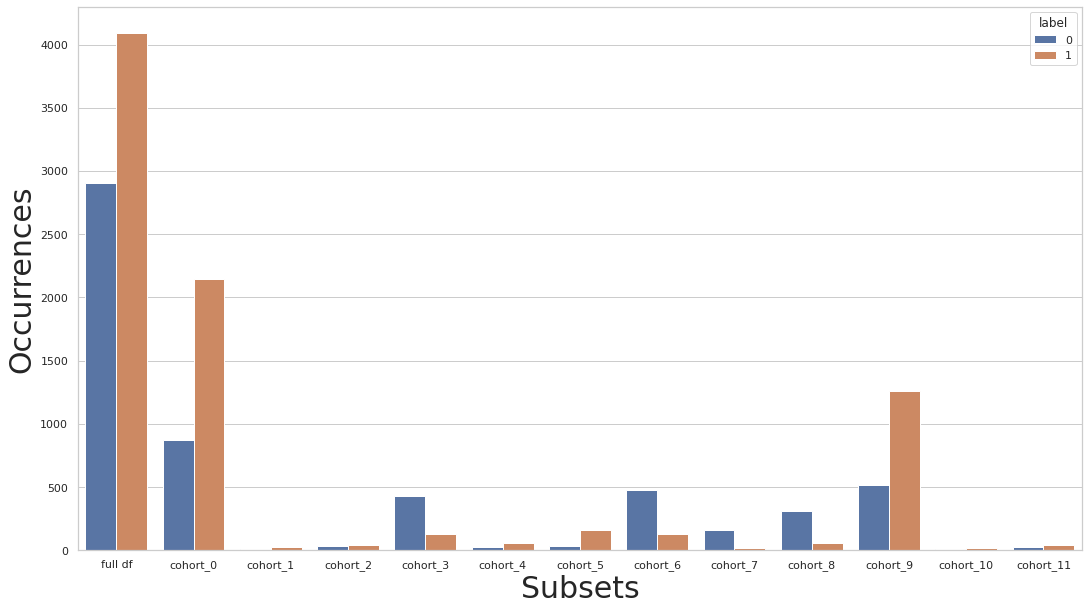

In [14]:
cohort_set = CohortManager(
    cohort_col=["sector", "country"]
)
cohort_set.fit(X=X_train, y=y_train)
subsets = cohort_set.get_subsets(X_train, y_train, apply_transform=False)

plot_value_counts_cohort(y_train, subsets, normalize=False)

As we can see, there is a slight class imbalance in the entire dataset, but if we look at each cohort individually, this imbalance varies greatly. We can see that the imbalance is inverted for some cohorts.

### Rebalance the entire dataset

For our first experiment, let's try rebalancing the entire dataset to see how this will affect the results. Note that we don't expect great changes to the results, since the imbalance in the entire dataset is not very accentuated.

We'll use the ``Rebalance`` class to rebalance the full dataset. We then plot the label distributions for all cohorts once again to see how the rebalance process affected the distributions inside each cohort.

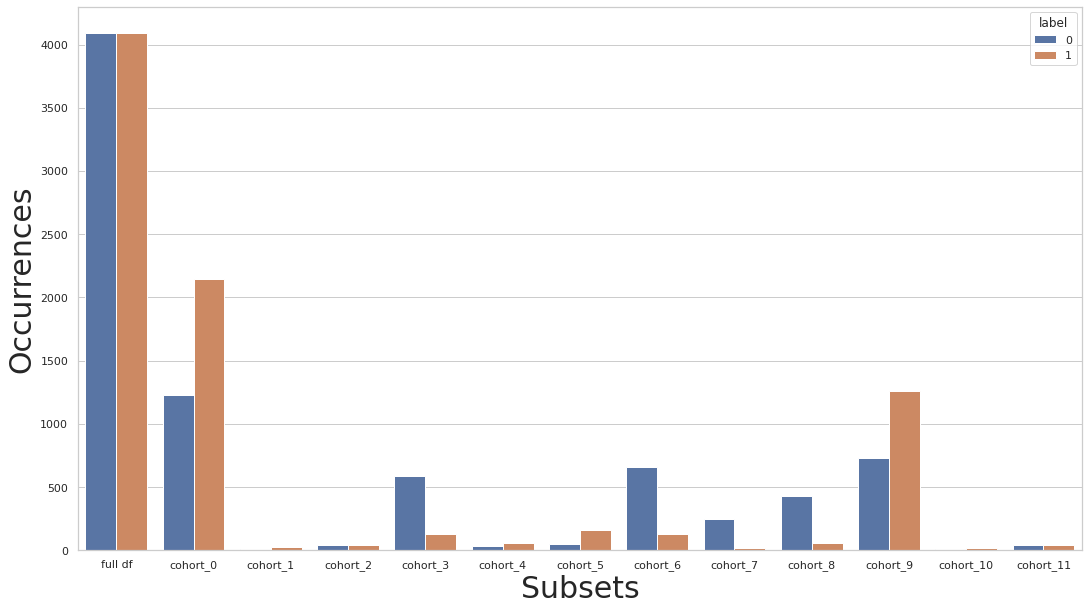

In [15]:
rebalance = dp.Rebalance(verbose=False)
new_X_train, new_y_train = rebalance.fit_resample(X_train, y_train)

cohort_set = CohortManager(
    cohort_col=["sector", "country"]
)
cohort_set.fit(X=X_train, y=y_train)
subsets = cohort_set.get_subsets(new_X_train,new_y_train, apply_transform=False)

plot_value_counts_cohort(new_y_train, subsets, normalize=False)

As we can see, after rebalancing the full dataset, there is no class imbalance when we look at the full dataset. However, the imbalance inside the cohorts with an inverted class imbalanced (compared to the full dataset) has only been more accentuated.

Let's now check how this new rebalanced dataset impacts the training process when using the baseline pipeline, where we train a single pipeline for the entire dataset.

In [16]:
pipe = Pipeline([
            ("imputer", dp.BasicImputer(verbose=False)),
            ("scaler", dp.DataMinMaxScaler(verbose=False)),
            ("encoder", dp.EncoderOHE(verbose=False)),
            ("estimator", get_model()),
        ])
pipe.fit(new_X_train, new_y_train)
pred_org = pipe.predict_proba(X_test)
    
fetch_cohort_results(X_test, y_test, pred_org, cohort_col=["sector", "country"])

/home/mmendonca/ResponsibleAI/code/git/responsible-ai-toolbox-mitigations-private/raimitigations/utils/model_utils.py:140: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)
/home/mmendonca/ResponsibleAI/code/git/responsible-ai-toolbox-mitigations-private/raimitigations/utils/model_utils.py:140: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)
/home/mmendonca/ResponsibleAI/code/git/responsible-ai-toolbox-mitigations-private/raimitigations/utils/model_utils.py:140: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)


,cohort,cht_query,cht_size,roc,threshold,pr,recall,f1,acc
0,all,all,3000,0.803268,0.639927,0.789100,0.790818,0.769648,0.769667
1,cohort_0,"(`sector` == ""s1"") and (`country` == ""A"")",1228,0.852323,0.639927,0.861257,0.896790,0.874579,0.889251
2,cohort_1,"(`sector` == ""s1"") and (`country` == ""B"")",13,0.238095,0.649560,0.791667,0.583333,0.511278,0.615385
3,cohort_2,"(`sector` == ""s1"") and (`country` == ""C"")",29,0.161905,0.715199,0.602564,0.538095,0.459110,0.551724
4,cohort_3,"(`sector` == ""s2"") and (`country` == ""A"")",291,0.803265,0.332855,0.930028,0.852337,0.882836,0.920962
5,cohort_4,"(`sector` == ""s2"") and (`country` == ""B"")",67,0.813390,0.342261,0.803529,0.867521,0.828205,0.880597
6,cohort_5,"(`sector` == ""s2"") and (`country` == ""C"")",106,0.775021,0.413488,0.701744,0.787014,0.730828,0.858491
7,cohort_6,"(`sector` == ""s3"") and (`country` == ""A"")",246,0.188799,0.125266,0.575122,0.529032,0.285017,0.304878
8,cohort_7,"(`sector` == ""s3"") and (`country` == ""B"")",76,0.710065,0.129994,0.885315,0.754386,0.792350,0.868421
9,cohort_8,"(`sector` == ""s3"") and (`country` == ""C"")",129,0.766817,0.168353,0.848348,0.785480,0.811509,0.899225


From the previous results, we can see that the results haven't changed much. This is true for the full dataset, as well as when we analyze each cohort individually. Therefore, this rebalancing process didn't impact the results for the baseline pipeline.

In the following cell, we use the rebalanced dataset in the cohort-based pipeline.

In [17]:
cht_manager = CohortManager(
    transform_pipe=[
        dp.BasicImputer(verbose=False),
        dp.DataMinMaxScaler(verbose=False),
        dp.EncoderOHE(verbose=False),
        get_model()
    ],
    cohort_col=["sector", "country"]
)
cht_manager.fit(new_X_train, new_y_train)
pred_cht = cht_manager.predict_proba(X_test)

fetch_cohort_results(X_test, y_test, pred_cht, cohort_col=["sector", "country"])

/home/mmendonca/ResponsibleAI/code/git/responsible-ai-toolbox-mitigations-private/raimitigations/utils/model_utils.py:140: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)
/home/mmendonca/anaconda3/envs/rai/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mmendonca/ResponsibleAI/code/git/responsible-ai-toolbox-mitigations-private/raimitigations/utils/model_utils.py:140: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)


,cohort,cht_query,cht_size,roc,threshold,pr,recall,f1,acc
0,all,all,3000,0.827125,0.637556,0.815023,0.820445,0.801822,0.802000
1,cohort_0,"(`sector` == ""s1"") and (`country` == ""A"")",1228,0.852323,0.637556,0.861257,0.896790,0.874579,0.889251
2,cohort_1,"(`sector` == ""s1"") and (`country` == ""B"")",13,0.761905,0.635485,0.888889,0.833333,0.837500,0.846154
3,cohort_2,"(`sector` == ""s1"") and (`country` == ""C"")",29,0.838095,0.466120,0.899038,0.895238,0.896057,0.896552
4,cohort_3,"(`sector` == ""s2"") and (`country` == ""A"")",291,0.196735,0.175744,0.549242,0.522471,0.509192,0.725086
5,cohort_4,"(`sector` == ""s2"") and (`country` == ""B"")",67,0.186610,1.643070,0.097015,0.500000,0.162500,0.194030
6,cohort_5,"(`sector` == ""s2"") and (`country` == ""C"")",106,0.224979,0.755883,0.567708,0.553763,0.216353,0.216981
7,cohort_6,"(`sector` == ""s3"") and (`country` == ""A"")",246,0.188799,0.170009,0.575122,0.529032,0.285017,0.304878
8,cohort_7,"(`sector` == ""s3"") and (`country` == ""B"")",76,0.710065,0.061715,0.885315,0.754386,0.792350,0.868421
9,cohort_8,"(`sector` == ""s3"") and (`country` == ""C"")",129,0.766817,0.122870,0.848348,0.785480,0.811509,0.899225


We can see that by comparing the previous results with the one obtained by using the cohort-based pipeline (the one for the cohorts based on the ``sector`` and ``country`` columns) over the original dataset, we can notice that the new rebalanced dataset performed considerably worse. Using the original dataset, we managed to get good metrics for the entire dataset and for each individual cohort. But when we use the rebalanced dataset, the metrics for some cohorts have become severely worse (for example, the metrics for cohort ``cohort_4``). One possible explanation for this is that, given that each cohort behaves very differently from the other, the new instances created by the SMOTE method (used internally by the ``Rebalance`` class) for some cohorts are not very befitting to the behavior analyzed in each cohort. This is especially true in smaller cohorts, that have fewer data points that can be used in the data creation process used in SMOTE. However, this has little impact when we train a pipeline over the full dataset since these small cohorts are already marginalized in these pipelines. But when we train a separate pipeline for each cohort, and we insert noisy data points into small cohorts, this noise has a great impact on the resulting estimator, as we can see from the previous results.

We can check this by printing the statistics for the investment column for all cohorts in the original dataset and for the rebalanced dataset. Notice how the value range changes drastically from the original to the rebalanced datasets for several cohorts. The mean and standard deviation also suffers great changes.

In [18]:
cohort_set = CohortManager(
    cohort_col=["sector", "country"]
)
cohort_set.fit(X=X_train, y=y_train)
subsets_original = cohort_set.get_subsets(X_train, y_train, apply_transform=False)
subsets_rebalance = cohort_set.get_subsets(new_X_train, new_y_train, apply_transform=False)

for cht_name in subsets_original.keys():
    min_value = subsets_original[cht_name]["X"]["investment"].min()
    max_value = subsets_original[cht_name]["X"]["investment"].max()
    mean = subsets_original[cht_name]["X"]["investment"].mean()
    std = subsets_original[cht_name]["X"]["investment"].std()
    print(f"{cht_name}:")
    print(f"\tORIGINAL: (min, max, mean, std) = ({min_value:e}, {max_value:e}, {mean:e}, {std:e})")
    min_value = subsets_rebalance[cht_name]["X"]["investment"].min()
    max_value = subsets_rebalance[cht_name]["X"]["investment"].max()
    mean = subsets_rebalance[cht_name]["X"]["investment"].mean()
    std = subsets_rebalance[cht_name]["X"]["investment"].std()
    print(f"\tREBALANCE: (min, max, mean, std) = ({min_value:e}, {max_value:e}, {mean:e}, {std:e})")

cohort_0:
	ORIGINAL: (min, max, mean, std) = (2.005068e+06, 9.998027e+06, 5.976259e+06, 2.339736e+06)
	REBALANCE: (min, max, mean, std) = (2.005068e+06, 1.098854e+13, 1.040341e+12, 3.217533e+12)
cohort_1:
	ORIGINAL: (min, max, mean, std) = (1.182911e+03, 4.987448e+03, 3.215314e+03, 1.206982e+03)
	REBALANCE: (min, max, mean, std) = (1.182911e+03, 1.098854e+13, 1.127030e+12, 3.377380e+12)
cohort_2:
	ORIGINAL: (min, max, mean, std) = (1.149726e+03, 4.982145e+03, 2.959479e+03, 1.251280e+03)
	REBALANCE: (min, max, mean, std) = (1.149726e+03, 1.098854e+13, 1.046528e+12, 3.244988e+12)
cohort_3:
	ORIGINAL: (min, max, mean, std) = (1.516971e+07, 1.499138e+09, 7.909766e+08, 4.417939e+08)
	REBALANCE: (min, max, mean, std) = (1.516971e+07, 1.098854e+13, 1.252196e+12, 3.492966e+12)
cohort_4:
	ORIGINAL: (min, max, mean, std) = (1.068535e+05, 1.493043e+06, 8.164178e+05, 4.428167e+05)
	REBALANCE: (min, max, mean, std) = (1.068535e+05, 1.098854e+13, 9.555261e+11, 3.113221e+12)
cohort_5:
	ORIGINAL: (min

### Rebalance only a specific cohort

Suppose now that we are interested in improving the performance over a single cohort, not the entire dataset. For example, let's consider that we are satisfied with the results obtained for all cohorts except for cohort ``cohort_7``. This way, we want to improve the metrics only for this cohort and try to leave the other cohorts as is. To this end, we'll use the ``Rebalance`` class once again, but this time we'll use it inside the ``CohortManager`` class. This way, we'll be able to rebalance only a specific set of cohorts. We'll use an empty list of transformations for all cohorts except for ``cohort_7``, which is the 8th cohort in the list.

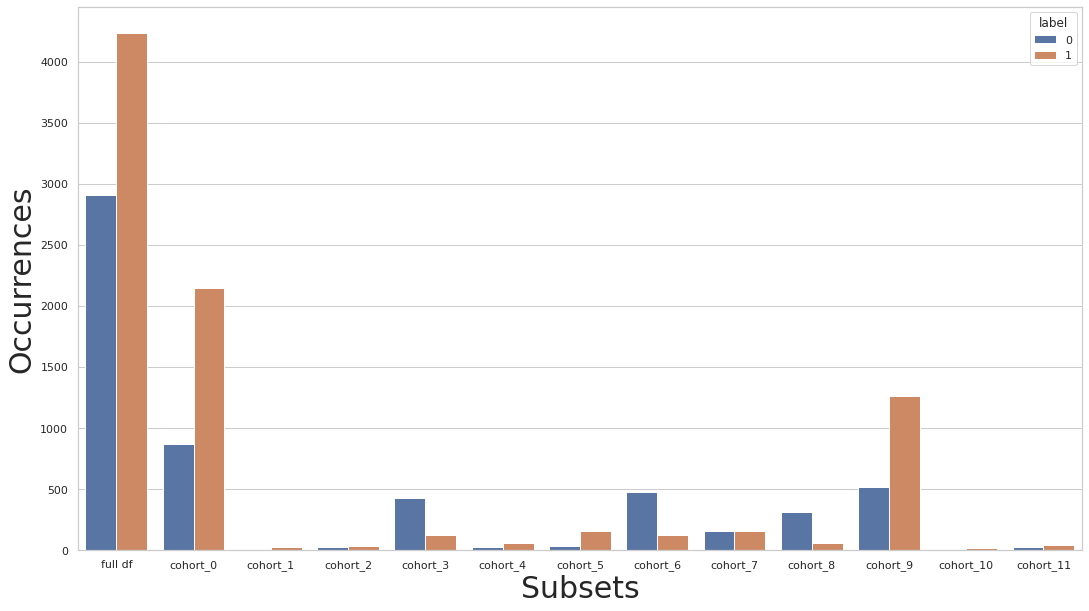

In [19]:

rebalance_cohort = CohortManager(
    transform_pipe=[[], [], [], [], [], [], [], [dp.Rebalance(verbose=False)], [], [], [], []],
    cohort_col=["sector", "country"]
)
new_X_train, new_y_train = rebalance_cohort.fit_resample(X_train, y_train)

subsets = rebalance_cohort.get_subsets(new_X_train,new_y_train, apply_transform=False)

plot_value_counts_cohort(new_y_train, subsets, normalize=False)

Let's check if the new instances created are very different from the original instances from cohort ``cohort_7``:

In [20]:
cohort_set = CohortManager(
    cohort_col=["sector", "country"]
)
cohort_set.fit(X=X_train, y=y_train)
subsets_original = cohort_set.get_subsets(X_train, y_train, apply_transform=False)
subsets_rebalance = cohort_set.get_subsets(new_X_train, new_y_train, apply_transform=False)

cht_name = "cohort_7"
min_value = subsets_original[cht_name]["X"]["investment"].min()
max_value = subsets_original[cht_name]["X"]["investment"].max()
mean = subsets_original[cht_name]["X"]["investment"].mean()
std = subsets_original[cht_name]["X"]["investment"].std()
print(f"{cht_name}:")
print(f"\tORIGINAL: (min, max, mean, std) = ({min_value:e}, {max_value:e}, {mean:e}, {std:e})")
min_value = subsets_rebalance[cht_name]["X"]["investment"].min()
max_value = subsets_rebalance[cht_name]["X"]["investment"].max()
mean = subsets_rebalance[cht_name]["X"]["investment"].mean()
std = subsets_rebalance[cht_name]["X"]["investment"].std()
print(f"\tREBALANCE: (min, max, mean, std) = ({min_value:e}, {max_value:e}, {mean:e}, {std:e})")

cohort_7:
	ORIGINAL: (min, max, mean, std) = (5.059673e+04, 2.994070e+05, 1.814661e+05, 7.001416e+04)
	REBALANCE: (min, max, mean, std) = (5.059673e+04, 2.994070e+05, 1.383858e+05, 7.739440e+04)


As we can see, the values for the ``investment`` column suffered only slight changes to the mean and standard deviation. This shows that in some cases, rebalancing certain cohorts separately is less harmful than rebalancing the entire dataset.

With our new rebalanced dataset, let's repeat the previous experiments:
1. train the baseline pipeline over the rebalanced dataset;
2. train the cohort-based pipeline over the rebalanced dataset;

In the following cell, we perform the first of these two experiments:

In [21]:
pipe = Pipeline([
            ("imputer", dp.BasicImputer(verbose=False)),
            ("scaler", dp.DataMinMaxScaler(verbose=False)),
            ("encoder", dp.EncoderOHE(verbose=False)),
            ("estimator", get_model()),
        ])
pipe.fit(new_X_train, new_y_train)
pred_org = pipe.predict_proba(X_test)
    
fetch_cohort_results(X_test, y_test, pred_org, cohort_col=["sector", "country"])

/home/mmendonca/ResponsibleAI/code/git/responsible-ai-toolbox-mitigations-private/raimitigations/utils/model_utils.py:140: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)
/home/mmendonca/ResponsibleAI/code/git/responsible-ai-toolbox-mitigations-private/raimitigations/utils/model_utils.py:140: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)
/home/mmendonca/ResponsibleAI/code/git/responsible-ai-toolbox-mitigations-private/raimitigations/utils/model_utils.py:140: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)


,cohort,cht_query,cht_size,roc,threshold,pr,recall,f1,acc
0,all,all,3000,0.804837,0.712906,0.788642,0.790417,0.769313,0.769333
1,cohort_0,"(`sector` == ""s1"") and (`country` == ""A"")",1228,0.852323,0.712906,0.861257,0.896790,0.874579,0.889251
2,cohort_1,"(`sector` == ""s1"") and (`country` == ""B"")",13,0.238095,0.893269,0.791667,0.583333,0.511278,0.615385
3,cohort_2,"(`sector` == ""s1"") and (`country` == ""C"")",29,0.161905,0.782414,0.602564,0.538095,0.459110,0.551724
4,cohort_3,"(`sector` == ""s2"") and (`country` == ""A"")",291,0.803265,0.377947,0.930028,0.852337,0.882836,0.920962
5,cohort_4,"(`sector` == ""s2"") and (`country` == ""B"")",67,0.813390,0.671898,0.803529,0.867521,0.828205,0.880597
6,cohort_5,"(`sector` == ""s2"") and (`country` == ""C"")",106,0.775021,0.468042,0.701744,0.787014,0.730828,0.858491
7,cohort_6,"(`sector` == ""s3"") and (`country` == ""A"")",246,0.188799,0.196127,0.575122,0.529032,0.285017,0.304878
8,cohort_7,"(`sector` == ""s3"") and (`country` == ""B"")",76,0.710065,0.451353,0.885315,0.754386,0.792350,0.868421
9,cohort_8,"(`sector` == ""s3"") and (`country` == ""C"")",129,0.766817,0.261151,0.848348,0.785480,0.811509,0.899225


As we can see, the results obtained are very similar to the baseline pipeline over the original dataset. This was already expected, since ``cohort_7`` is a small cohort, and since we are training a single pipeline over the entire dataset, the new instances added had little impact on the results of the other cohorts.

Let's now check how this rebalancing process impacts the cohort-based pipeline:

In [22]:
cht_manager = CohortManager(
    transform_pipe=[
        dp.BasicImputer(verbose=False),
        dp.DataMinMaxScaler(verbose=False),
        dp.EncoderOHE(verbose=False),
        get_model()
    ],
    cohort_col=["sector", "country"]
)
cht_manager.fit(new_X_train, new_y_train)
pred_cht = cht_manager.predict_proba(X_test)

fetch_cohort_results(X_test, y_test, pred_cht, cohort_col=["sector", "country"])

,cohort,cht_query,cht_size,roc,threshold,pr,recall,f1,acc
0,all,all,3000,0.923553,0.481561,0.907360,0.899210,0.902657,0.906333
1,cohort_0,"(`sector` == ""s1"") and (`country` == ""A"")",1228,0.911655,0.445408,0.942981,0.895519,0.915060,0.932410
2,cohort_1,"(`sector` == ""s1"") and (`country` == ""B"")",13,0.904762,0.704639,0.845238,0.845238,0.845238,0.846154
3,cohort_2,"(`sector` == ""s1"") and (`country` == ""C"")",29,0.914286,0.485884,0.899038,0.895238,0.896057,0.896552
4,cohort_3,"(`sector` == ""s2"") and (`country` == ""A"")",291,0.861716,0.528316,0.930028,0.852337,0.882836,0.920962
5,cohort_4,"(`sector` == ""s2"") and (`country` == ""B"")",67,0.814815,0.552434,0.914912,0.836895,0.868782,0.925373
6,cohort_5,"(`sector` == ""s2"") and (`country` == ""C"")",106,0.874276,0.689291,0.929167,0.840778,0.878077,0.952830
7,cohort_6,"(`sector` == ""s3"") and (`country` == ""A"")",246,0.875000,0.481561,0.943813,0.877957,0.905093,0.934959
8,cohort_7,"(`sector` == ""s3"") and (`country` == ""B"")",76,0.787627,0.747631,0.885315,0.754386,0.792350,0.868421
9,cohort_8,"(`sector` == ""s3"") and (`country` == ""C"")",129,0.780353,0.358148,0.848348,0.785480,0.811509,0.899225


Notice that we managed to get a slight improvement over the ROC AUC metric for ``cohort_7``, although the other metrics were left unchanged. It is interesting to note that the threshold used for ``cohort_7`` changed considerably when compared to the cohort-based pipeline trained over the original dataset.